In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/MyDrive/code/growth")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/ベイズ（論文2）/投稿用code/growth'

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.rcParams['font.sans-serif'] = ['Arial'] 
import scipy.optimize
import pandas as pd
import seaborn as sns
import pickle
import math

In [ ]:
data = pd.read_csv("data/frequentism_fitting.csv")
t = data['TIME']
N = data['Nt']
N0 = N[0]

In [ ]:
#fitting (frequentism)
parameter_initial = np.array([0.8,1.2])
def func(t,mu, lag):
    N = N0 + (0*(t<=lag) + np.log10(np.exp(mu*(t-lag)))*(t>lag))
    return N
parameter_optimal, covariance= scipy.optimize.curve_fit(func, t, N, p0=parameter_initial)
print("mu =", format(parameter_optimal[0]))
print("lag =", format(parameter_optimal[1]))

mu = 0.6793805146714833
lag = 2.175005610151201


In [ ]:
#prediction
T = np.arange(0,18.05,0.05)
Y = func(T,parameter_optimal[0],parameter_optimal[1])

In [ ]:
#calculate RMSE
T1 = np.arange(0,18,2)
Y1 = []
for j in range(len(T1)):
    y1 = Y[T1[j]*20]
    Y1.append(y1)
RMSE = np.sqrt(mean_squared_error(Y1,N))
print("RMSE= ", format(RMSE))

RMSE=  0.04581597288412522


In [ ]:
#import fitting result
with open('data/model-growth.pkl','rb') as f:
    model = pickle.load(f)
with open('data/result-growth.pkl','rb') as g:
    fit_nuts = pickle.load(g)
mu = fit_nuts['mu']
lag = fit_nuts['lag']
N0_mean = 6167

In [ ]:
#time
T2 = []
for i in range(180):
    t = i * 0.1
    T2.append(t)
#confidence interval
y_conf_int = np.zeros((len(mu),len(T2)))
for i in range(len(mu)):
    N0 = N0_mean
    for j in range(len(T2)):
        if N0 == 0:
            y_conf_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))) <= 1:
            y_conf_int[i,j] = N0*(math.exp(mu[i]*(T2[j]-lag[i])))
        else:
            y_conf_int[i,j] = N0

y_conf_upper0 = y_conf_int[y_conf_int[:,0] != 0]
y_conf_upper0_975 = np.percentile(y_conf_upper0, 2.5, axis=0)
y_conf_upper0_025 = np.percentile(y_conf_upper0, 97.5, axis=0)
y_conf_upper0_500 = np.percentile(y_conf_upper0, 50.0, axis=0)
y_conf = np.log10(y_conf_upper0)
y_conf_975 = np.percentile(y_conf, 2.5, axis=0)
y_conf_025 = np.percentile(y_conf, 97.5, axis=0)
y_conf_500 = np.percentile(y_conf, 50.0, axis=0)


In [ ]:
#predicted interval
y_pred_int = np.zeros((len(mu),len(T2)))
for i in range(len(mu)):
    N0 = np.random.poisson(N0_mean)
    for j in range(len(T2)):
        if N0 == 0:
            y_pred_int[i,j] = 0
        elif  0 <= N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))) <= 1:
            y_pred_int[i,j] = N0 + np.random.negative_binomial(N0, N0/(N0*math.exp(mu[i]*(T2[j]-lag[i]))), size=1)
        else:
            y_pred_int[i,j] = N0

y_pred_upper0 = y_pred_int[y_pred_int[:,0] != 0]
y_pred_upper0_975 = np.percentile(y_pred_upper0, 2.5, axis=0)
y_pred_upper0_025 = np.percentile(y_pred_upper0, 97.5, axis=0)
y_pred_upper0_500 = np.percentile(y_pred_upper0, 50.0, axis=0)
y_pred = np.log10(y_pred_upper0)
y_pred_975 = np.percentile(y_pred, 2.5, axis=0)
y_pred_025 = np.percentile(y_pred, 97.5, axis=0)
y_pred_500 = np.percentile(y_pred, 50.0, axis=0)


<Figure size 432x288 with 0 Axes>

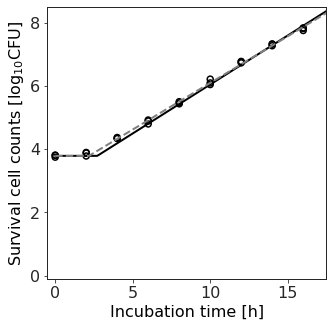

In [ ]:
#graph
data2 = pd.read_csv('data/bayesian_fitting.csv')
TIME = data2['TIME']
N1 = data2['Nt']
N_new = N1 *(10 ** data2['Dilution'])
data2['N_new'] = N_new
fig = plt.figure()
plt.style.use('ggplot')
sns.set_style(style='ticks')
plt.figure(figsize=(5,5))
plt.ylabel('Survival cell counts [$\log_{10}$CFU]',fontsize=16, color='k')
plt.xlabel('Incubation time [h]', fontsize=16, color='k')
plt.tick_params(labelsize=16, direction='out')
plt.xlim(-0.5,17.5)
plt.ylim(-0.1,8.5)
plt.xticks([0,5,10,15])
plt.scatter(TIME, np.log10(N_new), edgecolors ='k', facecolors='none', linewidths=1.5)
plt.plot(T2,y_conf_50, linestyle = 'solid', zorder=1, color='k', lw=2.0) #bayesian
plt.plot(T,Y,color='gray',linestyle='dashed',lw=2,zorder=2) #frequentism